In [10]:
!git clone https://github.com/arunponnusamy/object-detection-opencv.git

fatal: destination path 'object-detection-opencv' already exists and is not an empty directory.


In [ ]:
%cd object-detection-opencv/

/content/object-detection-opencv


In [11]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-12-27 13:22:07--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  20.6MB/s    in 12s     

2022-12-27 13:22:20 (19.1 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [20]:
import cv2
import argparse
import numpy as np
from google.colab.patches import cv2_imshow

In [21]:
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True,
                help = 'path to input image')
ap.add_argument('-c', '--config', required=True,
                help = 'path to yolo config file')
ap.add_argument('-w', '--weights', required=True,
                help = 'path to yolo pre-trained weights')
ap.add_argument('-cl', '--classes', required=True,
                help = 'path to text file containing class names')

def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/maxresdefault.jpg')

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

classes = None

with open('/content/object-detection-opencv/yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

In [22]:
net = cv2.dnn.readNet('/content/yolov3.weights', '/content/object-detection-opencv/yolov3.cfg')

blob = cv2.dnn.blobFromImage(image, scale, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

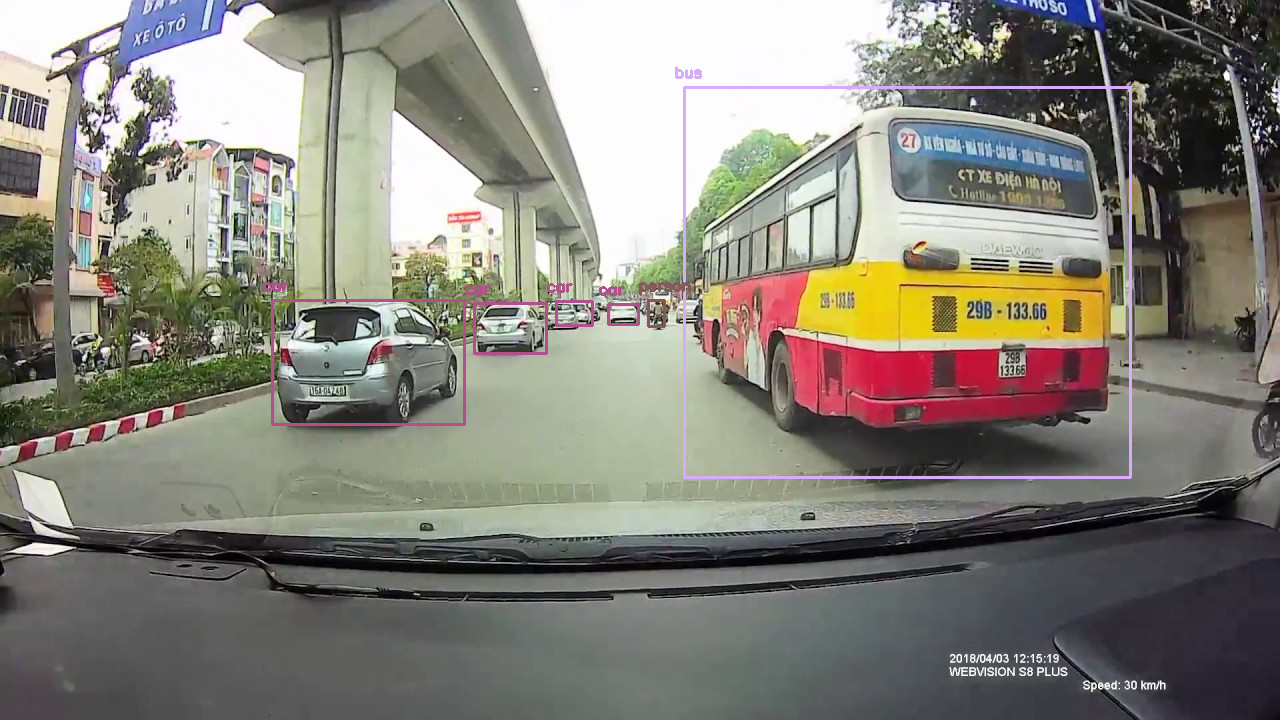

In [26]:
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # print(confidence)
        if confidence > 0.95:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

for i in indices:
    try:
        box = boxes[i]
    except:
        i = i[0]
        box = boxes[i]
    
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x + w), round(y + h))
  
cv2_imshow(image)
cv2.waitKey()


cv2.destroyAllWindows()